In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label
from lr.stats.h_testing import  LIMts_test, get_matched_results, get_boot_p_value
from lr.stats.h_testing import  get_paired_t_statistic, get_boot_sample_under_H0
from lr.stats.h_testing import  Ensemble, DGP

from lr.training.util import filter_df_by_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.text_processing.transformations.wordnet import path_base_transformation
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Loading data

In [2]:
train_path = "data/snli/train.csv"
dev_path = "data/snli/dev.csv"

train_path_mod = "data/snli/train_p_h_syn_noun.csv"
dev_path_mod = "data/snli/dev_p_h_syn_noun.csv"

train_trans = lambda df: path_base_transformation(df, train_path_mod)
dev_trans = lambda df: path_base_transformation(df, dev_path_mod)


train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
train = filter_df_by_label(train.dropna()).reset_index(drop=True)
dev = filter_df_by_label(dev.dropna()).reset_index(drop=True)

train = train.head(10000)
dev = dev.head(1000)

dev_t = dev_trans(dev)

pre_process_nli_df(train)
pre_process_nli_df(dev)

In [3]:
print(train.shape)
print(dev.shape)

(10000, 3)
(1000, 3)


### Checking data

In [4]:
s = train.sample(3)
s

,premise,hypothesis,label
3847,tourists enjoying a hot air balloon type ride,people are sitting in a balloon,entailment
9490,a man in a blue canoe paddling in the ocean,a man is paddling a canoe for exercise,neutral
2326,a room full of children raise their hands fing...,there is a room full of children,entailment


In [5]:
train_trans(s)

,premise,hypothesis,label
3847,tourists enjoying a hot air balloon type drive,people are sitting in a balloon,entailment
9490,a adult male in a blue canoe paddling in the o...,a adult male is paddling a canoe for workout,neutral
2326,a room full of child hike their hands fingers ...,there is a room full of child,entailment


### Params

In [6]:
max_features = None

param_grid = {"C": np.linspace(0, 3, 50),
              "penalty":["l2"]}


hyperparams = {"RepresentationFunction": Tfidf,
               "cv":5,
               "solver": 'lbfgs',
               "verbose":True,
               "n_jobs":1,
               "n_iter":2,
               "random_state":42,
               "max_features": max_features,
               "label_translation": get_ternary_label,
               "param_grid": param_grid}


## DGP

In [7]:
dgp = DGP(train, train_trans, rho=0.3)
train_ = dgp.sample(random_state=24)

### Naive Training in 2 parts

In [8]:
lr1 = LRWrapper(hyperparams)
lr1.fit(train_)
print(lr1.get_acc(train_))
print(lr1.model.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.5s finished


0.6469
{'penalty': 'l2', 'C': 0.7959183673469388}


In [9]:
hyperparams["random_state"] = 56

lr2 = LRWrapper(hyperparams)
lr2.fit(train_)
print(lr2.get_acc(train_))
print(lr2.model.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.9s finished


0.7087
{'penalty': 'l2', 'C': 2.4489795918367347}


In [10]:
accs = [lr2.get_acc(train_), lr1.get_acc(train_)]
print(np.mean(accs), np.std(accs))

0.6778 0.030899999999999983


In [11]:
lr = Ensemble([lr1, lr2])

print(lr.get_acc(train_))

0.6834


### Get t statistic for the observable results and matched results

- {'penalty': 'l2', 'C': 0.7959183673469388}

- {'penalty': 'l2', 'C': 2.4489795918367347}

lr acc = 0.6834

t = -0.3104751733020508



In [12]:

results = get_matched_results(dev, dev_t, lr, lr.label_translation)
t_obs = get_paired_t_statistic(results)

print(t_obs)

-0.3104751733020508


### Get $S$ bootstrap replications under H0

In [13]:
S = 1000
t_boots = []
for _ in range(S):
    boot_sample = get_boot_sample_under_H0(results)
    t = get_paired_t_statistic(boot_sample)
    t_boots.append(t)

t_boots = pd.Series(t_boots)

### Calculating the associated p-value

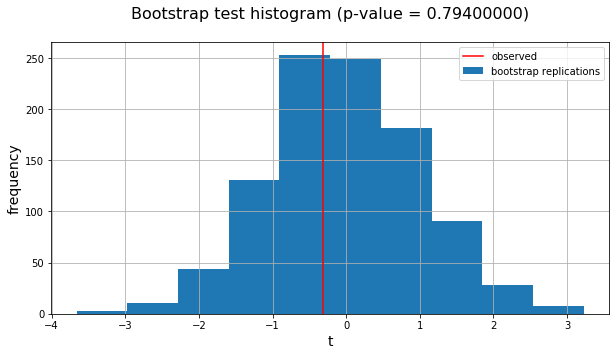

In [14]:
p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed");
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");

### Performing multiple tests

**test1: entailment internalization**

In [15]:
# M,E,S = 5,2,1000


# tests1 = LIMts_test(train=train,
#                     dev=dev,
#                     train_transformation=train_trans,
#                     dev_transformation=dev_trans,
#                     rho=0.78,
#                     Model=LRWrapper,
#                     hyperparams=hyperparams,
#                     M=M,
#                     E=E,
#                     S=S)

# tests1